In [0]:
import numpy as np
import chainer
from chainer import dataset
import matplotlib.pyplot as plt

線形変換層の定義

In [0]:
class Linear(object):
  def __init__(self, input_dim, output_dim, batch_size):
      self.W = np.random.normal(
          0,(2/batch_size)**(1/2) ,(input_dim, output_dim)).astype(np.float32)
      self.b = np.zeros(output_dim, dtype=np.float32)

  def forward(self, x):
      '''
      Args:
          x(np.array):(batchsize, input_dim) shape array.
      Returns:
          y(np.array):(batchsize, output_dim) shape array.
      '''
      self.x = x
      y = np.dot(x, self.W) + self.b
      return y
  def backward(self, gy):
      '''
      Args:
          gy(np.array):(batchsize, output_dim) shape array.
      Returns:
          gx(np.array):(batchsize, input_dim) shape array.
      '''
      self.gW = np.dot(self.x.T, gy)
      self.gb = np.sum(gy, axis = 0)
      gx = np.dot(gy, self.W.T)
      return gx

活性化関数ReLUの定義

In [0]:
class ReLU(object):
    def forward(self, x):
        self.x = x
        return np.maximum(x, 0)
    def backward(self, gy):
        gx = np.where(self.x>0, gy, 0)
        return gx

出力層の関数softmaxの定義

In [0]:
class softmax(object):
    def forward(self, x):
        z = np.max(x)
        y = np.exp(x - z)
        return y / y.sum(axis = 1, keepdims=True)

lossとしてsoftmax cross entropyを使う。softmaxと相性がよく、backwardが書きやすいため。

In [0]:
class SoftmaxCrossEntropy(object):
    def softmax(self, x):
        z = np.max(x)
        y = np.exp(x - z)
        return y / y.sum(axis = 1, keepdims=True)
    
    def forward(self, x, t):
        self.x = x
        self.t = t
        self.y = self.softmax(x)
        loss = - np.log((self.y)[np.arange(len(t)),t] + 1e-7)
        return loss.sum()
    def backward(self):
        gx = self.y.copy()
        gx[np.arange(len(self.t)),self.t] -= 1
        return gx

正答率をみる関数

In [0]:
class Accuracy (object):
    def correct_ratio(self, y, t):
        z = np.zeros_like(y)
        w = np.argmax(y, axis=1)
        z[np.arange(len(w)),w] = 1
        rate = np.mean(z[np.arange(len(t)),t])
        return rate.sum()

今回使うデータの確認

In [9]:
train, test = chainer.datasets.get_mnist()
print('data type:',type(train))

data type: <class 'chainer.datasets.tuple_dataset.TupleDataset'>


In [16]:
print('train len:',len(train))
x, t = train[0]
print('x type:',type(x))
print('t type:',type(t))

print('x shape:',x.shape)
#784 = 28*28
#784は28ピクセル四方の画像のシルバースケールを一次元に並べたもの
print('x dtype:',x.dtype)

train len: 60000
x type: <class 'numpy.ndarray'>
t type: <class 'numpy.int32'>
x shape: (784,)
x dtype: float32


モデル定義(今回は３層の全結合層で組む。)

In [0]:
class MODEL(object):
  def __init__(self, wh, label_num, batch_num):
    self.wh = wh
    self.label   = label_num
    self.batch   = batch_num
    self.linear0 = Linear(self.wh*self.wh, 144, self.batch)
    self.relu0   = ReLU()
    self.linear1 = Linear(144, 36, self.batch)
    self.relu1   = ReLU()
    self.linear2 = Linear(36, self.label, self.batch)
    self.sce     = SoftmaxCrossEntropy()
    self.ACCURACY= Accuracy()
  
  def forward(self, x, t):
    h = self.linear0.forward(x)
    h = self.relu0.forward(h)
    h = self.linear1.forward(h)
    h = self.relu1.forward(h)
    y = self.linear2.forward(h)
    loss = self.sce.forward(y, t)/self.batch
    accuracy = self.ACCURACY.correct_ratio(y, t)
    return loss, accuracy
  
  def backward(self):
    gh = self.sce.backward()
    gh = self.linear2.backward(gh)
    gh = self.relu1.backward(gh)
    gh = self.linear1.backward(gh)
    gh = self.relu0.backward(gh)
    gh = self.linear0.backward(gh)
    self.linear0.W -= learning_rate * self.linear0.gW
    self.linear0.b -= learning_rate * self.linear0.gb
    self.linear1.W -= learning_rate * self.linear1.gW
    self.linear1.b -= learning_rate * self.linear1.gb
    self.linear2.W -= learning_rate * self.linear2.gW
    self.linear2.b -= learning_rate * self.linear2.gb
    return

定義

In [0]:
n_epoch = 50
batchsize = 1200
learning_rate = 0.00025
wh = 28
label_num = 10

model = MODEL(wh, label_num, batchsize)

データの取得

In [0]:
train, test = chainer.datasets.get_mnist()

X = []
T = []
for x,t,in train:
    X.append(x)
    T.append(t)
    
X = np.array(X, dtype = np.float32)
T = np.array(T, dtype = np.int32)

trainのみ

In [50]:
iteration = 0
iteration_list = []
loss_list = []
accuracy_list = []
print('train')
for epoch in range(n_epoch):
    print('epoch:',epoch)
    sum_loss = 0.
    perm = np.random.permutation(len(X))
    
    for i in range(0, len(X), batchsize):
        x_batch = X[perm[i: i+batchsize]]
        t_batch = T[perm[i: i+batchsize]]
        
        loss, accuracy = model.forward(x_batch,t_batch)
        iteration_list.append(iteration)
        loss_list.append(loss)
        accuracy_list.append(accuracy)
        iteration += 1
        sum_loss += loss
        model.backward()
    print('sum_loss:',sum_loss)

train
epoch: 0
sum_loss: 94.43402414957683
epoch: 1
sum_loss: 37.81516281127929
epoch: 2
sum_loss: 22.71073504130046
epoch: 3
sum_loss: 16.39922861735026
epoch: 4
sum_loss: 13.951685485839844
epoch: 5
sum_loss: 12.145998217264813
epoch: 6
sum_loss: 11.00994018554687
epoch: 7
sum_loss: 9.986368929545085
epoch: 8
sum_loss: 9.070678863525393
epoch: 9
sum_loss: 8.371352907816568
epoch: 10
sum_loss: 7.742406234741211
epoch: 11
sum_loss: 7.206195818583171
epoch: 12
sum_loss: 6.756366577148439
epoch: 13
sum_loss: 6.416169439951578
epoch: 14
sum_loss: 5.987094523111979
epoch: 15
sum_loss: 5.631593716939291
epoch: 16
sum_loss: 5.287041969299318
epoch: 17
sum_loss: 5.075279566446938
epoch: 18
sum_loss: 4.822085393269858
epoch: 19
sum_loss: 4.708171011606852
epoch: 20
sum_loss: 4.32192216873169
epoch: 21
sum_loss: 4.183187319437662
epoch: 22
sum_loss: 3.9036533101399735
epoch: 23
sum_loss: 3.780278294881186
epoch: 24
sum_loss: 3.595368010203043
epoch: 25
sum_loss: 3.444131371180217
epoch: 26
sum_

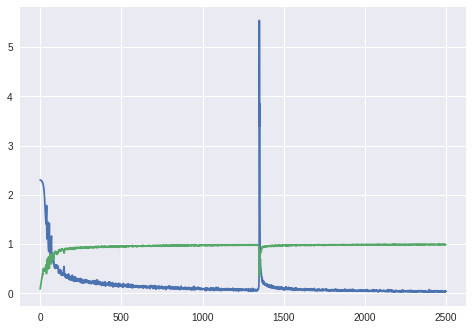

In [52]:
plt.plot(np.array(iteration_list),np.array(loss_list))
plt.plot(np.array(iteration_list),np.array(accuracy_list))
plt.show()

testのみ

In [53]:
X = []
T = []
for x,t,in test:
    X.append(x)
    T.append(t)
    
X = np.array(X, dtype = np.float32)
T = np.array(T, dtype = np.int32)

iteration = 0
iteration_list = []
loss_list = []
accuracy_list = []
print('Test')
    
for i in range(0, X.shape[0], batchsize):
  x_batch = X[i:i+batchsize]
  t_batch = T[i:i+batchsize]
  loss, accuracy = model.forward(x_batch,t_batch)
  iteration_list.append(iteration)
  loss_list.append(loss)
  accuracy_list.append(accuracy)
  iteration += 1
print('finish')

Test
finish


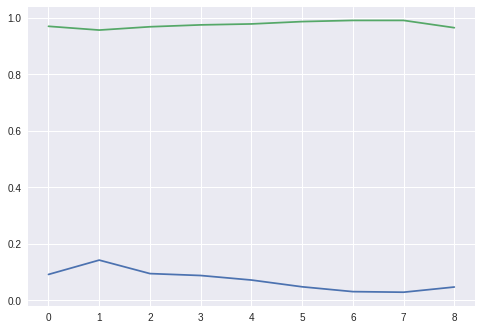

In [54]:
plt.plot(np.array(iteration_list),np.array(loss_list))
plt.plot(np.array(iteration_list),np.array(accuracy_list))
plt.show()

train, test

In [74]:
train, test = chainer.datasets.get_mnist()

train_X = []
train_T = []
for x,t,in train:
    train_X.append(x)
    train_T.append(t)
train_X = np.array(train_X, dtype = np.float32)
train_T = np.array(train_T, dtype = np.int32)

test_X = []
test_T = []
for x,t,in test:
    test_X.append(x)
    test_T.append(t)    
test_X = np.array(test_X, dtype = np.float32)
test_T = np.array(test_T, dtype = np.int32)

epoch_list = []
train_loss_list = []
train_accuracy_list = []

test_loss_list = []
test_accuracy_list = []

for epoch in range(n_epoch):
    print('epoch:',epoch)
    sum_loss = 0.
    perm = np.random.permutation(len(train_X))
    epoch_list.append(epoch)
    
    for i in range(0, len(train_X), batchsize):
        x_batch = train_X[perm[i: i+batchsize]]
        t_batch = train_T[perm[i: i+batchsize]]
        
        loss, accuracy = model.forward(x_batch,t_batch)
        sum_loss += loss
        model.backward()
    train_loss_list.append(loss)
    train_accuracy_list.append(accuracy)    
    print(sum_loss)
    for j in range(0, len(test_X), batchsize):
        x_batch = test_X[j: j+batchsize]
        t_batch = test_T[j: j+batchsize]
        
        loss, accuracy = model.forward(x_batch,t_batch)
    test_loss_list.append(loss)
    test_accuracy_list.append(accuracy)

epoch: 0
89.62576700846355
epoch: 1
36.22414255777994
epoch: 2
21.24218335469563
epoch: 3
16.46712094624837
epoch: 4
14.226060638427734
epoch: 5
12.411244443257653
epoch: 6
11.17963269551595
epoch: 7
9.865629539489744
epoch: 8
8.991284370422363
epoch: 9
8.169829699198406
epoch: 10
7.535613396962483
epoch: 11
7.01446983973185
epoch: 12
13.151623191833497
epoch: 13
6.8256664403279625
epoch: 14
6.100877717336019
epoch: 15
5.67028367360433
epoch: 16
5.322581679026285
epoch: 17
5.011933561960855
epoch: 18
4.79514918645223
epoch: 19
4.480361150105794
epoch: 20
4.283351434071857
epoch: 21
4.093187173207601
epoch: 22
3.92973789215088
epoch: 23
3.7300055631001787
epoch: 24
3.5315978813171385
epoch: 25
3.4148494243621825
epoch: 26
3.298355875015259
epoch: 27
3.142640651067098
epoch: 28
3.007538391749064
epoch: 29
2.880313994089762
epoch: 30
2.798359851837159
epoch: 31
2.6744943618774406
epoch: 32
2.5755079078674314
epoch: 33
2.4417382780710857
epoch: 34
2.374820235570272
epoch: 35
2.277104126612

loss


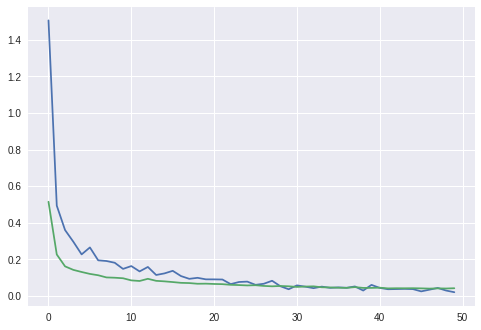

In [75]:
print('loss')
plt.plot(np.array(epoch_list),np.array(train_loss_list))
plt.plot(np.array(epoch_list),np.array(test_loss_list))
plt.show()

accuracy


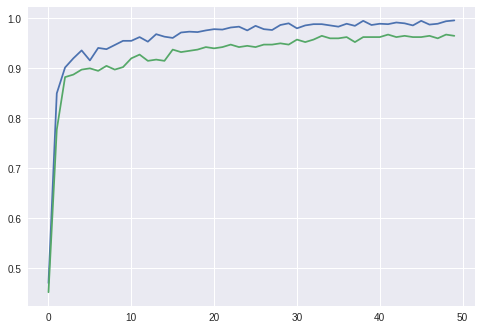

In [76]:
print('accuracy')
plt.plot(np.array(epoch_list),np.array(train_accuracy_list))
plt.plot(np.array(epoch_list),np.array(test_accuracy_list))
plt.show()